# **Genotype_Phenotype_CNN Project**

## **Importing important Libraries**

In [1]:
%matplotlib inline
%load_ext tensorboard
#!pip install keras-tuner
import pandas as pd
import numpy as np
import tensorflow as tf
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)
from matplotlib import pyplot as plt
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, accuracy_score

2023-04-27 16:04:51.056754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 16:04:51.165523: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 16:04:51.736776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/rkannan/miniconda3/envs/richard_tf/lib/
2023-04-27 16:04:51.736836: W tensorflow

## **Loading Datasets**

In [2]:
genotypeFile = 'genotype.csv'
genotype = pd.read_csv(genotypeFile, sep = '\t', index_col = 0)
print('genotypeFile shape:', genotype.shape )

phenotypeFile = 'phenotype.csv'
multi_pheno = pd.read_csv(phenotypeFile, sep = ',', index_col = 0)
print('Phenotype_Multi shape:', multi_pheno.shape )


# take a small part to test code
# genotype
X = genotype
# X = genotype.iloc[0:1000:, 0:5000]
# single_pheno
Y = multi_pheno.iloc[:, 12]#index=2 --> 1_E6-Berbamine_1
# Y = multi_pheno.iloc[0:1000, pheno_i]


# # Add noise
# random missing masker
missing_perc = 0.1
nonmissing_ones = np.random.binomial(
    1, 1 - missing_perc, size=X.shape[0] * X.shape[1])
nonmissing_ones = nonmissing_ones.reshape(X.shape[0], X.shape[1])
nonmissing_ones, nonmissing_ones.shape

corrupted_X = X * nonmissing_ones
# corrupted_X.head()

# # Prepare data
# ## One-hot encoding

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#X_onehot = to_categorical(X)
corrupted_X_onehot = to_categorical(corrupted_X)
# corrupted_X_onehot.shape

# normlization
scaled_Y = (Y - Y.min()) / (Y.max() - Y.min())


def detect_outliers(df):
    outlier_indices = []

    Q1 = np.percentile(df, 25)
    Q3 = np.percentile(df, 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR

    outlier_indices = df[(df < Q1 - outlier_step) |
                         (df > Q3 + outlier_step)].index

    return outlier_indices


temp_Y = scaled_Y[~scaled_Y.isna()]
outliers_index = detect_outliers(temp_Y)


# set outliers as NAN
scaled_Y_ = scaled_Y.copy()
scaled_Y_[outliers_index] = np.nan


# ## Split train and test
train_X, test_X, corrupted_train_X, corrupted_test_X, train_Y, test_Y = train_test_split(
    X, corrupted_X_onehot, scaled_Y_.iloc[:], test_size=0.1, random_state = 42)

# split df to train and valid
train_X, valid_X, corrupted_train_X, corrupted_valid_X, train_Y, valid_Y = train_test_split(
    train_X, corrupted_train_X, train_Y, test_size=0.1,random_state = 42)



x_train = to_categorical(pd.concat([train_X,train_Y],axis=1).dropna().iloc[:,0:-1])
y_train = train_Y.dropna().to_numpy()

x_valid = to_categorical(pd.concat([valid_X,valid_Y],axis=1).dropna().iloc[:,0:-1])
y_valid = valid_Y.dropna().to_numpy()

x_test = to_categorical(pd.concat([test_X,test_Y],axis=1).dropna().iloc[:,0:-1])
y_test  = test_Y.dropna().to_numpy()

genotypeFile shape: (4390, 28220)
Phenotype_Multi shape: (4390, 20)


## **PART 2 - BUILDING THE Model**

### Initializing the CNN and Building the layers

In [3]:
def model_build(pheno_name,num_hl,hl_list,hl_activation, out_activation, dropout_val,filters_, kernel_size_,stride_poolSize,Conv_Layers_Stride_Size):
    

    '''
    https://towardsdatascience.com/multi-output-model-with-tensorflow-keras-functional-api-875dd89aa7c6

    def DNN_build(num_hl,hl_list,hl_activation, out_activation, dropout_val):
    pheno_name = name of phenotype of interest
    num_hl = number of hidden layers
    hl_list = list of hidden layers
    hl_activation = hidden layer activation function
    out_activation = output layer activation function
    dropout_val = Dropout value
    '''
    assert(num_hl == len(hl_list))
    assert(num_hl == len(dropout_val))
    input_layer = tf.keras.Input(shape=(28220, 3))#(3138, 28220, 3)
    
    shared_convL1 = tf.keras.layers.Conv1D(filters = filters_,kernel_size = kernel_size_,strides = Conv_Layers_Stride_Size, activation = hl_activation,input_shape = (28220, 3))(input_layer)
    shared_convL1_max_pool = tf.keras.layers.MaxPool1D(pool_size=stride_poolSize, strides=stride_poolSize)(shared_convL1)
    
    shared_convL2 = tf.keras.layers.Conv1D(filters = filters_,kernel_size = kernel_size_,strides = Conv_Layers_Stride_Size, activation = hl_activation)(shared_convL1_max_pool)
    shared_convL2_max_pool = tf.keras.layers.MaxPool1D(pool_size=stride_poolSize, strides=stride_poolSize)(shared_convL2)
    
    shared_convLayer_Flatten = tf.keras.layers.Flatten()(shared_convL2_max_pool)
    initializer = tf.keras.initializers.HeNormal()
    kernel_regularizer_ = tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001)
    
    shared_hidden_layer1 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[0], activation  = hl_activation)(shared_convLayer_Flatten)
    shared_hidden_layer1_dp1 = tf.keras.layers.Dropout(dropout_val[0])(shared_hidden_layer1)

    #model 1
    model1_hidden_layer2 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[1], activation  = hl_activation)(shared_hidden_layer1_dp1)
    model1_hidden_layer2_dp2 = tf.keras.layers.Dropout(dropout_val[1])(model1_hidden_layer2)

    model1_hidden_layer3 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[2], activation  = hl_activation)(model1_hidden_layer2_dp2)
    model1_hidden_layer3_dp3 = tf.keras.layers.Dropout(dropout_val[2])(model1_hidden_layer3)

    model1_hidden_layer4 = tf.keras.layers.Dense(kernel_regularizer=kernel_regularizer_,kernel_initializer=initializer,units = hl_list[3], activation  = hl_activation)(model1_hidden_layer3_dp3)
    model1_hidden_layer4_dp4 = tf.keras.layers.Dropout(dropout_val[3])(model1_hidden_layer4)
    model1_hidden_layer4_dp4_fl = tf.keras.layers.Flatten()(model1_hidden_layer4_dp4)
    
    pheno_name_ = tf.keras.layers.Dense(units = 1, name = pheno_name, activation  = out_activation)(model1_hidden_layer4_dp4_fl)#1_CobaltChloride_1
    model = tf.keras.models.Model(inputs = input_layer, outputs = [pheno_name_])

    return model

## **PART 3 - TRAINING THE MODEL**

### **Compiling the CNN and Training the CNN on the Training set**

In [4]:
#ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])#change metrics to MSE
def compile_model(pheno_name,model,loss_, learningRate, metrics_): #loss = 'sparse_categorical_crossentropy'
    '''
    def compile_model(DNN, loss_, learningRate, metrics_):
    DNN: the model
    loss_: the loss function
    learningRate: learning rate
    metrics_: metrics of interest ['accuracy', 'mse']
    '''

    # Specify the optimizer, and compile the model with loss functions for both outputs
    model.compile(
       #optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate),#0.00027705 
    optimizer =  tf.keras.optimizers.SGD(learning_rate=learningRate, momentum=0.8, nesterov=True, name="SGD"),
      loss = {
          pheno_name:loss_
      }, 
      metrics = [metrics_]#{'CobaltChloride_1':[metrics_],'CopperSulfate_1':[metrics_],'Diamide_1':[metrics_]}
      )#change metrics to MSE ##['accuracy','mse']
    return model

def runModel(model, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode,pheno_index):
    '''
    def buildModel(DNN, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
    DNN: DNN which the model
    val_split_size: the validation split)
    batch_size_: batch_size
    numEpochs: number of epochs
    patience_: patience of call back
    monitor_: monitor (objective of callback)
    mode: mode (min, max, auto)
    pheno_index: the index of the phenotype in y_train
    '''
    history = model.fit(
    x_train, 
    [y_train[:]],
    validation_data=(x_valid, [y_valid[:]]),
    batch_size = batch_size_, 
    epochs = numEpochs,
    callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor= monitor_,patience=patience_,verbose=1,mode=mode),#monitoring loss mode should be min [---val_acc--]
      #tf.keras.callbacks.ModelCheckpoint(filepath='./TrainedModels/model.{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True),
      #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]
    )

    return history



## Model Evaluation

In [5]:
def evaluateModel_loss(history,model_name,label_loss,val_label_loss):
    print()
    plt.plot(history.history[label_loss])
    plt.plot(history.history[val_label_loss])
    plt.title(model_name + ' Training and Validation loss')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('epochs')
    plt.legend(['Training loss','Validation loss'], loc = 'upper left')
    #plt.savefig("Training_validation_loss_with_i.jpg")
    plt.show()
    plt.close()
    #plt.show()
    print()
def evaluateModel_metric(history,model_name,label_acc,val_label_acc):
    print()
    plt.plot(history.history[label_acc])
    plt.plot(history.history[val_label_acc])
    plt.title(model_name+' Training and Validation Mean Qquared Error')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('epochs')
    plt.legend(['Training Accuracy','Validation Accuracy'], loc = 'upper left')
    #plt.show()
    #plt.savefig("Training_validation_accuracy_with_i.jpg")
    plt.show()
    plt.close()
    print()

## **Putting it All Together**

In [6]:
def runModel_all(pheno_name, pheno_index,hl_list, drop_list):
    model_mse = model_build(pheno_name,4,hl_list,'relu','linear',drop_list,8,7,2,3)#model initiallization
    model_mse = compile_model(pheno_name,model_mse,tf.keras.losses.MeanSquaredError(reduction="auto", name="mse"),
    0.00123695244,'mse')
    history_mse =  runModel(model_mse,0.00,32,400,15, "val_mse", "min",pheno_index)
    return history_mse,model_mse

### Run for '1_Menadione_1' at index 1 in y_train

In [7]:
history_mse,model_mse = runModel_all('1_Menadione_1',3,[1464,608,264,146],[0.50,0.10,0.00,0.50])

2023-04-26 19:20:32.737371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 19:20:34.234273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14755 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-04-26 19:20:34.234925: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14755 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-04-26 19:20:34.235396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/tas

Epoch 1/400


2023-04-26 19:20:36.574920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-26 19:20:37.337751: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5fbd7240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-26 19:20:37.337777: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-04-26 19:20:37.337781: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2023-04-26 19:20:37.337784: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): Quadro RTX 5000, Compute Capability 7.5
2023-04-26 19:20:37.337786: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): Quadro RTX 5000, Compute Capability 7.5
2023-04-26 19:20:37.412477: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster usin

108/108 [==============================] - 5s 14ms/step - loss: 17.7466 - mse: 0.0809 - val_loss: 17.6746 - val_mse: 0.0459
Epoch 2/400
108/108 [==============================] - 1s 12ms/step - loss: 17.6221 - mse: 0.0295 - val_loss: 17.5884 - val_mse: 0.0328
Epoch 3/400
108/108 [==============================] - 1s 12ms/step - loss: 17.5437 - mse: 0.0240 - val_loss: 17.5111 - val_mse: 0.0283
Epoch 4/400
108/108 [==============================] - 1s 12ms/step - loss: 17.4695 - mse: 0.0226 - val_loss: 17.4373 - val_mse: 0.0271
Epoch 5/400
108/108 [==============================] - 1s 12ms/step - loss: 17.3955 - mse: 0.0210 - val_loss: 17.3626 - val_mse: 0.0248
Epoch 6/400
108/108 [==============================] - 1s 12ms/step - loss: 17.3210 - mse: 0.0188 - val_loss: 17.2925 - val_mse: 0.0269
Epoch 7/400
108/108 [==============================] - 1s 12ms/step - loss: 17.2497 - mse: 0.0196 - val_loss: 17.2181 - val_mse: 0.0245
Epoch 8/400
108/108 [==============================] - 1s 12

Epoch 61/400
108/108 [==============================] - 1s 12ms/step - loss: 13.6402 - mse: 0.0130 - val_loss: 13.6103 - val_mse: 0.0141
Epoch 62/400
108/108 [==============================] - 1s 12ms/step - loss: 13.5787 - mse: 0.0128 - val_loss: 13.5490 - val_mse: 0.0141
Epoch 63/400
108/108 [==============================] - 1s 12ms/step - loss: 13.5174 - mse: 0.0128 - val_loss: 13.4876 - val_mse: 0.0138
Epoch 64/400
108/108 [==============================] - 1s 12ms/step - loss: 13.4564 - mse: 0.0127 - val_loss: 13.4267 - val_mse: 0.0139
Epoch 65/400
108/108 [==============================] - 1s 12ms/step - loss: 13.3956 - mse: 0.0128 - val_loss: 13.3660 - val_mse: 0.0139
Epoch 66/400
108/108 [==============================] - 1s 12ms/step - loss: 13.3349 - mse: 0.0126 - val_loss: 13.3051 - val_mse: 0.0135
Epoch 67/400
108/108 [==============================] - 1s 12ms/step - loss: 13.2746 - mse: 0.0128 - val_loss: 13.2445 - val_mse: 0.0132
Epoch 68/400
108/108 [===================

108/108 [==============================] - 1s 12ms/step - loss: 7.6260 - mse: 0.0093 - val_loss: 7.6061 - val_mse: 0.0096
Epoch 181/400
108/108 [==============================] - 1s 12ms/step - loss: 7.5860 - mse: 0.0092 - val_loss: 7.5663 - val_mse: 0.0097
Epoch 182/400
108/108 [==============================] - 1s 12ms/step - loss: 7.5459 - mse: 0.0090 - val_loss: 7.5263 - val_mse: 0.0095
Epoch 183/400
108/108 [==============================] - 1s 12ms/step - loss: 7.5063 - mse: 0.0091 - val_loss: 7.4869 - val_mse: 0.0098
Epoch 184/400
108/108 [==============================] - 1s 12ms/step - loss: 7.4668 - mse: 0.0091 - val_loss: 7.4473 - val_mse: 0.0096
Epoch 185/400
108/108 [==============================] - 1s 12ms/step - loss: 7.4274 - mse: 0.0091 - val_loss: 7.4080 - val_mse: 0.0096
Epoch 186/400
108/108 [==============================] - 1s 12ms/step - loss: 7.3882 - mse: 0.0091 - val_loss: 7.3690 - val_mse: 0.0097
Epoch 187/400
108/108 [==============================] - 1s 12

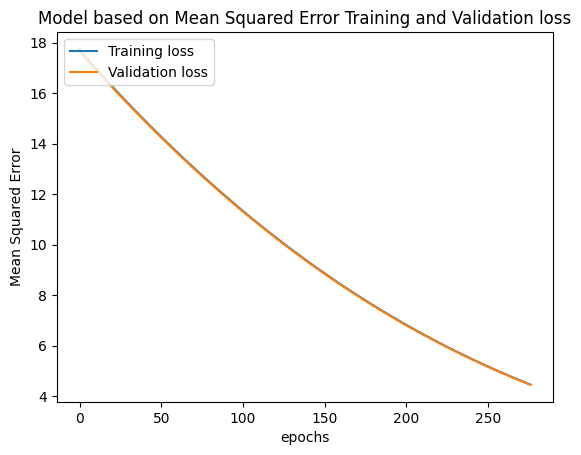

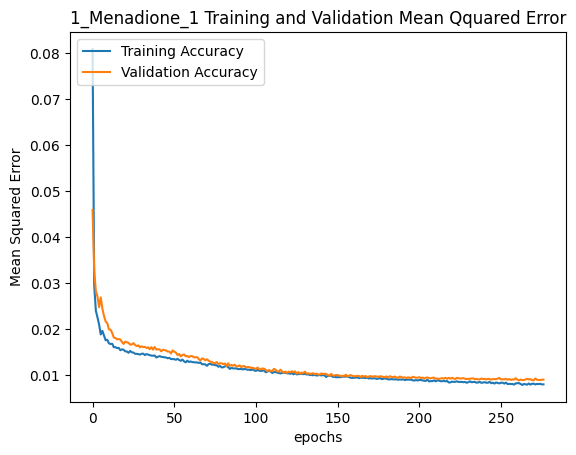

In [8]:
pheno_name='1_Menadione_1'
evaluateModel_loss(history_mse,'Model based on Mean Squared Error','loss','val_loss')
evaluateModel_metric(history_mse,pheno_name,'mse','val_mse')

In [9]:
model_mse.save('saved Models/1_Menadione_1.h5')

In [10]:
print(history_mse.history['val_mse'][-1])

0.008999444544315338


In [11]:
print(history_mse.history['mse'][-1])

0.007978606969118118


14/14 [==============================] - 0s 5ms/step
(1, 425)
count    425.000000
mean       0.472865
std        0.076782
min        0.327967
25%        0.406714
50%        0.473747
75%        0.536165
max        0.682505
Name: 1_Menadione_1, dtype: float64

count    425.000000
mean       0.479000
std        0.123014
min        0.150157
25%        0.384916
50%        0.486229
75%        0.567127
max        0.820785
Name: 1_Menadione_1_actual, dtype: float64


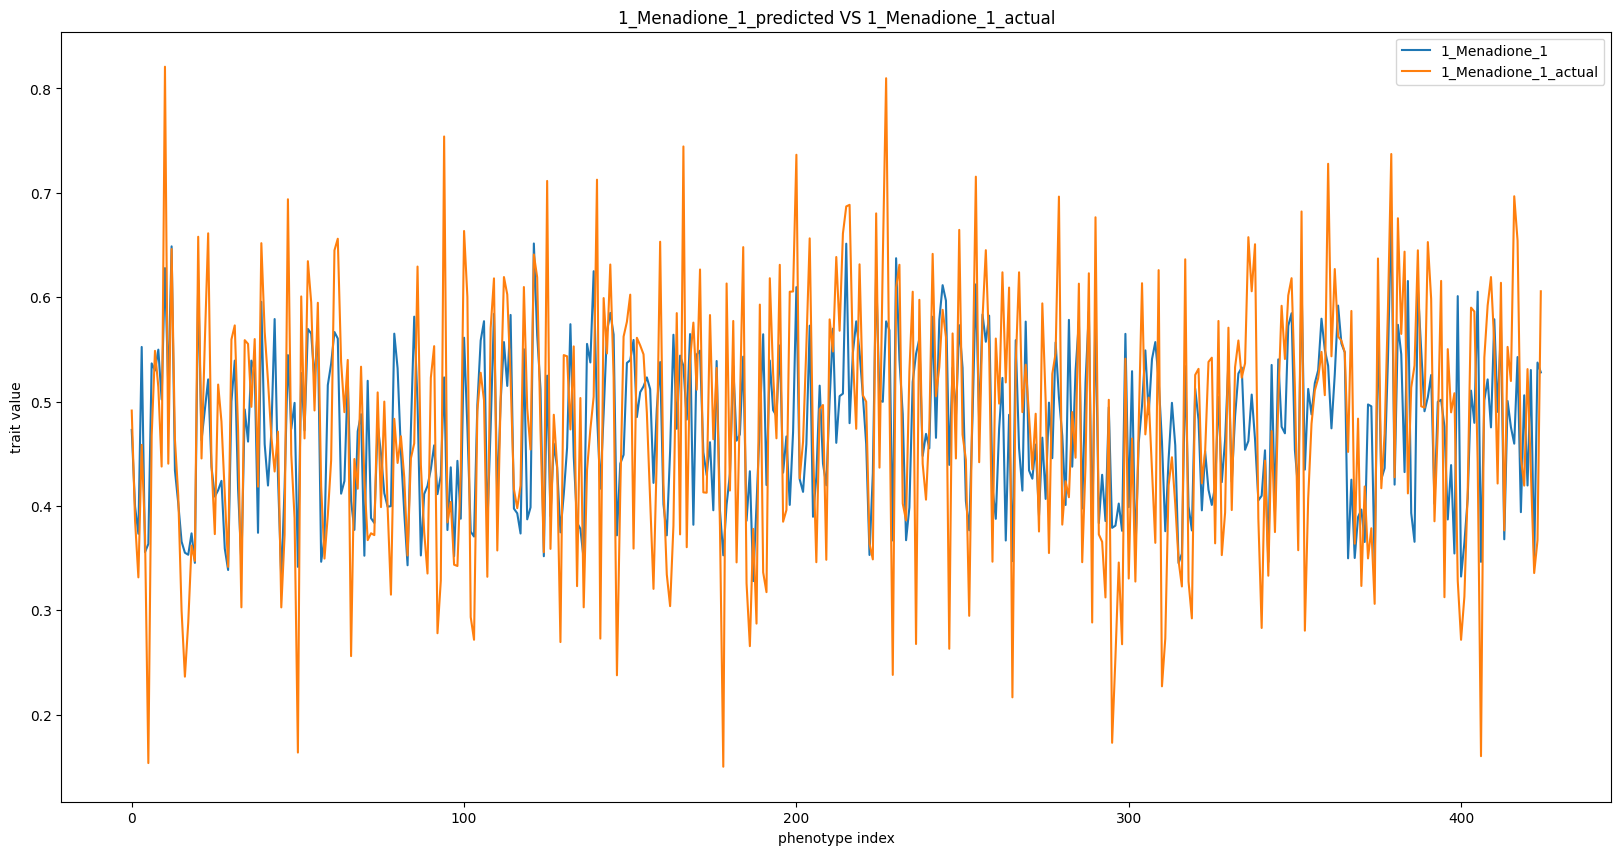

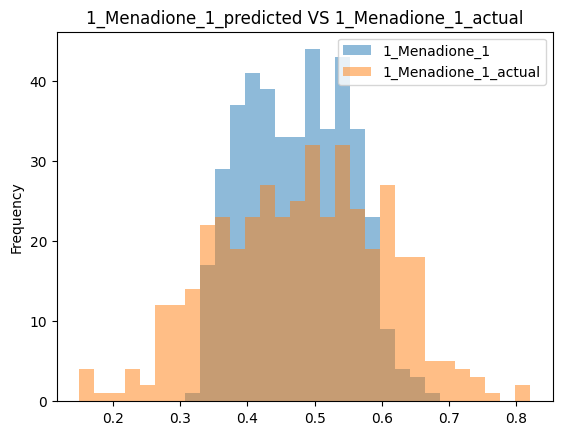

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm.auto import tqdm
import itertools

phenoName = '1_Menadione_1'
phenoIdx = 10
def modelEvals_test_data(phenoName, phenoIdx,model):
    predicted_labels = np.array(model.predict(np.stack(x_test.reshape((x_test.shape[0], 28220,3))))).T
    print(predicted_labels.shape)
    #print(predicted_labels[0,:])
    df = pd.DataFrame(predicted_labels[0,:],columns=[phenoName])
    df[str(phenoName+'_actual')] = y_test[:]
    print(df[phenoName].describe())
    print()
    print(df[str(phenoName+'_actual')].describe())
    
    pred1=df[[phenoName,str(phenoName+'_actual')]]
    pred1.plot.line(figsize=(20,10),title= str(phenoName+'_predicted' +' VS '+str(phenoName+'_actual')),xlabel='phenotype index',ylabel='trait value')
    pred1.plot.hist(bins=30, alpha=0.5, title= str(phenoName+'_predicted' +' VS '+str(phenoName+'_actual')),xlabel='phenotype Value',ylabel='Frequency')
modelEvals_test_data(phenoName, phenoIdx,model_mse)

In [3]:
#load saved model
model_mse = tf.keras.models.load_model('saved Models/1_Menadione_1.h5')
evaluate_data = model_mse.evaluate(
    x_test, y_test, verbose=1, batch_size=32)
#print(evaluate_data)

# predict
predict_data = model_mse.predict(x_test)

2023-04-27 16:05:23.347150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 16:05:25.004288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7961 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-04-27 16:05:25.004825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14167 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-04-27 16:05:25.005250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task

14/14 [==============================] - 0s 5ms/step
